In [62]:
import cobra
import os
import pandas as pd
from cobra.flux_analysis import flux_variability_analysis

In [4]:
models = {}
model_dir = '../data/modelseed_models/'
for file in os.listdir(model_dir):
    if file.endswith('.json'):
        models[file.split('.json')[0]] = cobra.io.load_json_model(model_dir+file)

In [5]:
models

{'L. lactis': <Model L. lactis at 0x11bbdfcf8>,
 'B. vulgatus HM-720': <Model B. vulgatus HM-720 at 0x11c0317f0>,
 'B. clarus': <Model B. clarus at 0x117452400>,
 'P. distasonis': <Model P. distasonis at 0x11cc870f0>,
 'C. saccharolyticum': <Model C. saccharolyticum at 0x11d398a20>,
 'L. plantarum': <Model L. plantarum at 0x11db8a780>,
 'P. merdae': <Model P. merdae at 0x11e4ab240>,
 'R. gnavus': <Model R. gnavus at 0x11e9af160>}

In [12]:
for species,model in models.items():
    print(species,model.optimize())

L. lactis <Solution 37.148 at 0x11f9ef748>
B. vulgatus HM-720 <Solution 117.824 at 0x11f9ef6a0>
B. clarus <Solution 113.243 at 0x11f9ef5c0>
P. distasonis <Solution 111.613 at 0x11f9ef6a0>
C. saccharolyticum <Solution 39.514 at 0x11f9ef630>
L. plantarum <Solution 56.456 at 0x11f9ef6a0>
P. merdae <Solution 97.011 at 0x11f9ef630>
R. gnavus <Solution 25.340 at 0x11f9ef6a0>


In [7]:
models['L. lactis'].optimize()

,fluxes,reduced_costs
rxn02201_c,0.000000,3.469447e-18
rxn00836_c,0.000000,-1.564112e-02
rxn00390_c,0.000000,0.000000e+00
rxn11567_c,0.000000,-0.000000e+00
rxn00423_c,163.927952,0.000000e+00
...,...,...
EX_cpd00393_e,0.000000,0.000000e+00
EX_cpd00028_e,-0.589880,0.000000e+00
EX_cpd11584_e,-3.044184,0.000000e+00
SK_cpd11416_c,37.147662,0.000000e+00


In [175]:
fva_results = {}
consumed_mets = {}
produced_mets = {}
for species,model in models.items():
    print("performing FVA for {}".format(species))
    ex_rxns = [r.id for r in model.reactions if r.id.startswith('EX_')]
    fva_results[species] = flux_variability_analysis(model,ex_rxns, fraction_of_optimum = 0.05)
    
    # get consistently consumed and produced metabolites from exchanges
    consumed_mets[species] = fva_results[species].loc[(fva_results[species] < -1e-6).sum(axis=1) > 1]
    produced_mets[species] = fva_results[species].loc[(fva_results[species] > 1e-6).sum(axis=1) > 1]
    

performing FVA for L. lactis
performing FVA for B. vulgatus HM-720
performing FVA for B. clarus
performing FVA for P. distasonis
performing FVA for C. saccharolyticum
performing FVA for L. plantarum
performing FVA for P. merdae
performing FVA for R. gnavus


In [176]:
# extract the lowest uptake rates
species_consumption_series = {species:consumed_mets[species]['maximum'] for species in consumed_mets.keys()}
uptake_frame = pd.DataFrame(species_consumption_series)
uptake_frame = uptake_frame.fillna(0).T
# normalize the uptake frame by the max of the metabolite across all species
#uptake_frame = uptake_frame.divide(uptake_frame.min())

In [177]:
# extract the highest secretion rates
species_production_series = {species:produced_mets[species]['minimum'] for species in produced_mets.keys()}
secretion_frame = pd.DataFrame(species_production_series)
secretion_frame = secretion_frame.fillna(0).T
# normalize the uptake frame by the max of the metabolite across all species
#secretion_frame = uptake_frame.divide(uptake_frame.min())

In [178]:
# merge the secretion and uptake dataframes, then normalize by the absolute max secretion/uptake
con_prod_frame = secretion_frame.add(uptake_frame, fill_value=0)

# normalize by max(abs)
con_prod_frame = con_prod_frame.divide(abs(con_prod_frame).max(axis=0))

In [180]:
con_prod_frame

,EX_cpd00001_e,EX_cpd00007_e,EX_cpd00009_e,EX_cpd00010_e,EX_cpd00011_e,EX_cpd00013_e,EX_cpd00023_e,EX_cpd00028_e,EX_cpd00030_e,EX_cpd00034_e,...,EX_cpd03422_e,EX_cpd03696_e,EX_cpd03847_e,EX_cpd10516_e,EX_cpd11583_e,EX_cpd11584_e,EX_cpd11591_e,EX_cpd11606_e,EX_cpd15605_e,EX_cpd15606_e
L. lactis,0.0,0.0000,0.000000,-0.657991,0.0,0.0,0.0,-0.657991,-0.657991,-0.657991,...,0.000000,-0.657991,0.000000,-0.657991,-1.0,-0.344098,0.000000,0.000000,0.000000,-0.301839
B. vulgatus HM-720,0.0,0.0000,-1.000000,0.000000,0.0,-1.0,0.0,-0.661316,-0.813927,-0.813927,...,-0.780337,0.000000,-1.000000,-0.966538,0.0,0.000000,0.000000,-1.000000,0.000000,0.000000
B. clarus,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,-0.586713,-0.782284,-0.782284,...,-1.000000,0.000000,-0.961123,-0.977855,0.0,0.000000,-1.000000,-0.640749,-1.000000,-1.000000
P. distasonis,0.0,0.0000,-0.951365,0.000000,0.0,0.0,0.0,-0.771025,-0.771025,-0.771025,...,0.000000,0.000000,-0.947291,-0.771025,0.0,-1.000000,0.000000,-0.947291,-0.985608,-0.985608
C. saccharolyticum,0.0,1.0000,0.000000,0.000000,0.0,0.0,0.0,-0.524925,-0.699900,-0.699900,...,-0.894688,-0.699900,0.000000,-0.874876,0.0,0.000000,0.000000,-0.573271,0.000000,0.000000
L. plantarum,0.0,0.0000,0.000000,-1.000000,0.0,0.0,0.0,-1.000000,-1.000000,-1.000000,...,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000,0.000000,-0.819074,0.000000,0.000000
P. merdae,1.0,0.0000,-0.885823,0.000000,1.0,0.0,0.0,-0.670154,-0.670154,-0.670154,...,0.000000,0.000000,-0.823360,-0.670154,0.0,-0.869173,-0.856664,-0.823360,-0.856664,-0.856664
R. gnavus,0.0,-0.0163,-0.348362,-0.448849,0.0,0.0,-1.0,-0.448849,-0.448849,-0.448849,...,0.000000,-0.448849,0.000000,-0.448849,0.0,0.000000,0.000000,-0.367640,0.000000,0.000000


In [187]:
shadow_price_dict = {}
for species,model in models.items():
    medium = model.medium
    medium = {cpd:1 for cpd in medium.keys()}
    model.medium = medium
    shadow_prices = model.optimize().shadow_prices
    shadow_prices = shadow_prices[[cpd for cpd in shadow_prices.index if cpd.endswith('_e')]]
    shadow_price_dict[species] = shadow_prices
    
shadow_price_frame = pd.DataFrame(shadow_price_dict)
shadow_price_frame = shadow_price_frame.fillna(0)

# remove metabolites with small shadow prices
shadow_price_frame = shadow_price_frame.loc[abs(shadow_price_frame).max(axis=1) > 1e-8].T

In [189]:
shadow_price_frame

,cpd00007_e,cpd00011_e,cpd00013_e,cpd00024_e,cpd00027_e,cpd00033_e,cpd00053_e,cpd00054_e,cpd00067_e,cpd00080_e,...,cpd00276_e,cpd00277_e,cpd00309_e,cpd00311_e,cpd00314_e,cpd00367_e,cpd00396_e,cpd00550_e,cpd00588_e,cpd00794_e
L. lactis,-1.220642e-02,-9.493885e-03,-1.356269e-03,0.000000,-8.137615e-03,0.000000e+00,0.000000e+00,0.000000,-1.220642e-02,0.000000e+00,...,-0.009494,0.000000,0.000000e+00,0.000000,-0.004069,0.000000,0.000000e+00,0.000000,-0.000000,-1.627523e-02
B. vulgatus HM-720,-3.385876e-14,-0.000000e+00,-2.022614e-01,0.000000,-4.788274e-15,0.000000e+00,0.000000e+00,0.000000,6.280472e-17,0.000000e+00,...,0.000000,0.000000,1.833361e-14,0.000000,0.000000,0.000000,2.170725e-14,0.000000,0.000000,0.000000e+00
B. clarus,-5.252905e-02,-0.000000e+00,-2.775558e-17,0.000000,-3.151743e-01,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,-1.313226e-01,...,0.000000,-0.026265,-0.000000e+00,-0.052529,0.000000,-0.026265,0.000000e+00,0.000000,0.000000,0.000000e+00
P. distasonis,3.568493e-17,-1.802970e-15,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.087575e-01,0.000000e+00,...,0.000000,0.000000,8.648455e-17,0.000000,0.000000,0.000000,-4.350300e-01,0.000000,0.000000,0.000000e+00
C. saccharolyticum,-0.000000e+00,-2.379983e-02,-1.189992e-02,0.000000,2.255141e-17,-2.379983e-02,-1.189992e-02,-0.023800,-1.189992e-02,1.028991e-17,...,-0.011900,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.650192e-18
L. plantarum,-7.825166e-03,-1.173775e-02,-0.000000e+00,-0.003913,-2.347550e-02,3.561387e-15,1.633242e-15,-0.003913,-1.173775e-02,9.103829e-15,...,-0.023475,0.000000,-3.912583e-03,0.000000,-0.019563,0.000000,0.000000e+00,-0.003913,-0.019563,-4.695100e-02
P. merdae,-8.344619e-02,-0.000000e+00,0.000000e+00,0.000000,-4.589540e-01,0.000000e+00,0.000000e+00,0.000000,-1.272806e-16,0.000000e+00,...,0.000000,0.000000,2.044792e-16,0.000000,0.000000,0.000000,-4.172309e-01,0.000000,0.000000,0.000000e+00
R. gnavus,-9.355728e-14,-2.470636e-02,1.734723e-18,0.000000,2.775558e-17,0.000000e+00,0.000000e+00,0.000000,-1.235318e-02,0.000000e+00,...,-0.012353,0.000000,7.756801e-17,0.000000,-0.000000,0.000000,0.000000e+00,0.000000,-0.000000,-0.000000e+00


In [137]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

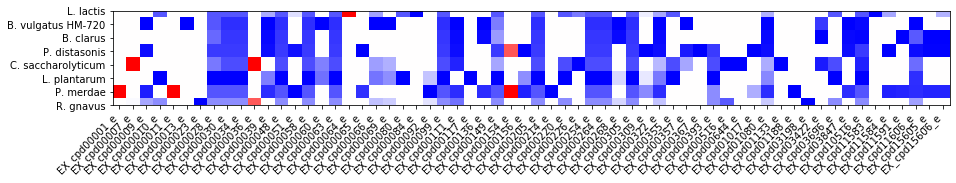

In [179]:
fig,ax = plt.subplots()

# construct the custom colormap

im = ax.imshow(con_prod_frame.values, cmap = 'bwr')
ax.set_xticks(np.arange(len(con_prod_frame.columns)))
ax.set_yticks(np.arange(len(con_prod_frame.index)))
ax.set_xticklabels(con_prod_frame.columns, rotation = 45, ha = 'right')
ax.set_yticklabels(con_prod_frame.index)
fig.set_size_inches(15,5)

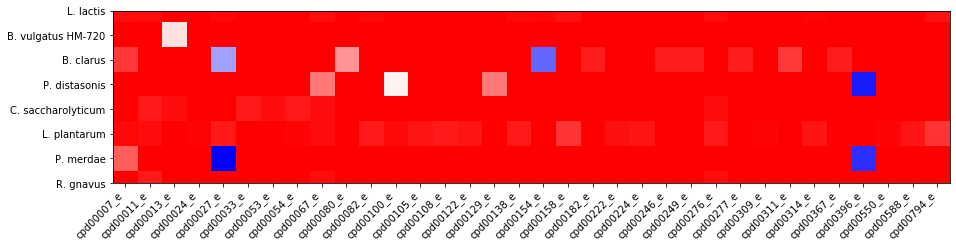

In [190]:
fig,ax = plt.subplots()

# construct the custom colormap

im = ax.imshow(shadow_price_frame.values, cmap = 'bwr')
ax.set_xticks(np.arange(len(shadow_price_frame.columns)))
ax.set_yticks(np.arange(len(shadow_price_frame.index)))
ax.set_xticklabels(shadow_price_frame.columns, rotation = 45, ha = 'right')
ax.set_yticklabels(shadow_price_frame.index)
fig.set_size_inches(15,5)

In [42]:
# find best pairs for each species for consumption of produced metabolites
for species,consumed in consumed_mets.items():
    best_overlap = (None,0)
    print('Finding partner for {}'.format(species))
    for paired_species,produced in produced_mets.items():
        overlap = len(produced.intersection(consumed))
        print('\toverlap with {0}: {1}'.format(paired_species,overlap))
        if overlap > best_overlap[1]:
            best_overlap = (paired_species,overlap)
    print('best partner was {0} with overlap of {1}'.format(best_overlap[0],best_overlap[1]))

Finding partner for L. lactis
	overlap with L. lactis: 0
	overlap with B. vulgatus HM-720: 2
	overlap with B. clarus: 0
	overlap with P. distasonis: 0
	overlap with C. saccharolyticum: 1
	overlap with L. plantarum: 1
	overlap with P. merdae: 0
	overlap with R. gnavus: 2
best partner was B. vulgatus HM-720 with overlap of 2
Finding partner for B. vulgatus HM-720
	overlap with L. lactis: 0
	overlap with B. vulgatus HM-720: 0
	overlap with B. clarus: 1
	overlap with P. distasonis: 2
	overlap with C. saccharolyticum: 3
	overlap with L. plantarum: 1
	overlap with P. merdae: 1
	overlap with R. gnavus: 1
best partner was C. saccharolyticum with overlap of 3
Finding partner for B. clarus
	overlap with L. lactis: 0
	overlap with B. vulgatus HM-720: 0
	overlap with B. clarus: 0
	overlap with P. distasonis: 0
	overlap with C. saccharolyticum: 1
	overlap with L. plantarum: 0
	overlap with P. merdae: 0
	overlap with R. gnavus: 0
best partner was C. saccharolyticum with overlap of 1
Finding partner 

In [44]:
# Find best pairs of species based on minimization of consumption overlap
for species,consumed in consumed_mets.items():
    best_overlap = (None,1000000)
    print('Finding partner for {}'.format(species))
    for paired_species,pair_consumption in consumed_mets.items():
        overlap = len(pair_consumption.intersection(consumed))
        print('\toverlap with {0}: {1}'.format(paired_species,overlap))
        if overlap < best_overlap[1]:
            best_overlap = (paired_species,overlap)
    print('best partner was {0} with overlap of {1}'.format(best_overlap[0],best_overlap[1]))

Finding partner for L. lactis
	overlap with L. lactis: 34
	overlap with B. vulgatus HM-720: 18
	overlap with B. clarus: 18
	overlap with P. distasonis: 20
	overlap with C. saccharolyticum: 22
	overlap with L. plantarum: 26
	overlap with P. merdae: 22
	overlap with R. gnavus: 22
best partner was B. vulgatus HM-720 with overlap of 18
Finding partner for B. vulgatus HM-720
	overlap with L. lactis: 18
	overlap with B. vulgatus HM-720: 32
	overlap with B. clarus: 23
	overlap with P. distasonis: 22
	overlap with C. saccharolyticum: 22
	overlap with L. plantarum: 21
	overlap with P. merdae: 22
	overlap with R. gnavus: 23
best partner was L. lactis with overlap of 18
Finding partner for B. clarus
	overlap with L. lactis: 18
	overlap with B. vulgatus HM-720: 23
	overlap with B. clarus: 28
	overlap with P. distasonis: 22
	overlap with C. saccharolyticum: 18
	overlap with L. plantarum: 19
	overlap with P. merdae: 24
	overlap with R. gnavus: 19
best partner was L. lactis with overlap of 18
Finding

{'L. lactis': {'EX_cpd00010_e',
  'EX_cpd00013_e',
  'EX_cpd00028_e',
  'EX_cpd00030_e',
  'EX_cpd00034_e',
  'EX_cpd00039_e',
  'EX_cpd00048_e',
  'EX_cpd00051_e',
  'EX_cpd00058_e',
  'EX_cpd00063_e',
  'EX_cpd00066_e',
  'EX_cpd00067_e',
  'EX_cpd00080_e',
  'EX_cpd00084_e',
  'EX_cpd00099_e',
  'EX_cpd00149_e',
  'EX_cpd00158_e',
  'EX_cpd00205_e',
  'EX_cpd00220_e',
  'EX_cpd00226_e',
  'EX_cpd00254_e',
  'EX_cpd00264_e',
  'EX_cpd00276_e',
  'EX_cpd00305_e',
  'EX_cpd00309_e',
  'EX_cpd00322_e',
  'EX_cpd00355_e',
  'EX_cpd00794_e',
  'EX_cpd01080_e',
  'EX_cpd03696_e',
  'EX_cpd10516_e',
  'EX_cpd11583_e',
  'EX_cpd11584_e',
  'EX_cpd15606_e'},
 'B. vulgatus HM-720': {'EX_cpd00007_e',
  'EX_cpd00009_e',
  'EX_cpd00013_e',
  'EX_cpd00023_e',
  'EX_cpd00028_e',
  'EX_cpd00030_e',
  'EX_cpd00034_e',
  'EX_cpd00039_e',
  'EX_cpd00048_e',
  'EX_cpd00058_e',
  'EX_cpd00060_e',
  'EX_cpd00063_e',
  'EX_cpd00066_e',
  'EX_cpd00069_e',
  'EX_cpd00099_e',
  'EX_cpd00111_e',
  'EX_cpd00136